### In this notebook we consider the influence of temporal or spatial averaging on fluxes

In turbulent flows, the "turbulent dispersion relation" roughly follows a curve that moves to higher spatial scales at higher temporal scales (finer flows are faster flows). 
This implies that when we perform a filtering along one direction (say space), it automatically results in a filtering in the other direction (say time). 

Here we make a few plots to look at this behavior. 

In [1]:
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
import numpy as np
from xgcm import Grid
import xrft

%matplotlib inline

In [2]:
ds_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored/'

ds = xr.open_zarr('/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/')

## Impact on tracer field

In [3]:
T_field = ds['T']
C_field = ds['PTRACER01']

### Power spectrum 

In [105]:
T_sel = T_field.isel(time=slice(0, 1800)).sel(XC=slice(0, 1000e3), YC=slice(500e3, 1500e3)).sel(Z=-1000, method='nearest').drop(['Depth', 'hFacC', 'maskC', 'rA', 'iter']).chunk({'XC':200, 'time':600, 'YC':10})
T_sel['time'] = ((T_sel.time - T_sel.time[0])/1e9/24/3600).astype('float')

C_sel = C_field.isel(time=slice(0, 1800)).sel(XC=slice(0, 1000e3), YC=slice(500e3, 1500e3)).sel(Z=-1000, method='nearest').drop(['Depth', 'hFacC', 'maskC', 'rA', 'iter']).chunk({'XC':200, 'time':600, 'YC':10})
C_sel['time'] = ((C_sel.time - C_sel.time[0])/1e9/24/3600).astype('float')

In [106]:
T_k_om_ps = xrft.power_spectrum(T_sel, dim=['XC', 'time'] , chunks_to_segments=True).rename('T_k_om_ps').mean(['YC', 'time_segment', 'XC_segment'])
C_k_om_ps = xrft.power_spectrum(C_sel, dim=['XC', 'time'] , chunks_to_segments=True).rename('C_k_om_ps').mean(['YC', 'time_segment', 'XC_segment'])
#T_k_om_ps = xrft.power_spectrum(T_k_ps, dim=['time'] )

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


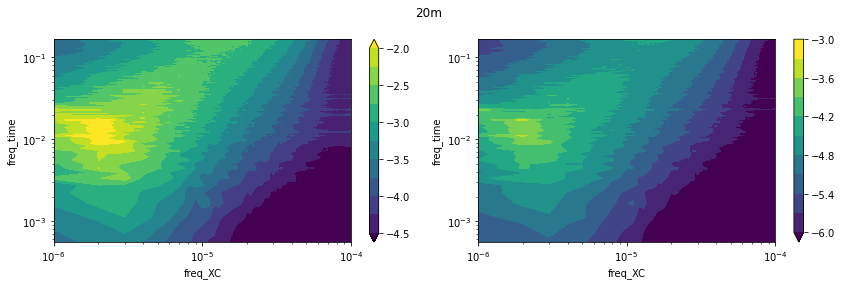

In [104]:
k = T_k_om_ps.freq_XC
om = T_k_om_ps.freq_time

plt.figure(figsize=(12, 4))
plt.subplot(121)
np.log10(T_k_om_ps*k*om).plot.contourf(levels=np.linspace(-4.5,-2, 11))

plt.xlim([1/1000e3, 1/10e3])
plt.ylim([1/1800, 1/6])

plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
np.log10(C_k_om_ps*k*om).plot.contourf(levels=np.linspace(-6,-3,11))

plt.xlim([1/1000e3, 1/10e3])
plt.ylim([1/1800, 1/6])

plt.xscale('log')
plt.yscale('log')

plt.suptitle('20m')
plt.tight_layout()


/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


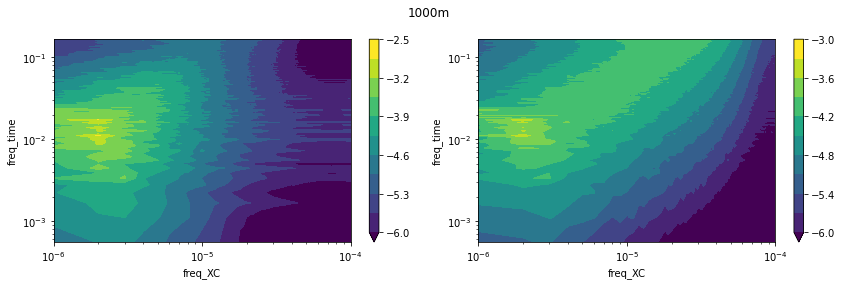

In [109]:
k = T_k_om_ps.freq_XC
om = T_k_om_ps.freq_time

plt.figure(figsize=(12, 4))
plt.subplot(121)
np.log10(T_k_om_ps*k*om).plot.contourf(levels=np.linspace(-6,-2.5, 11))

plt.xlim([1/1000e3, 1/10e3])
plt.ylim([1/1800, 1/6])

plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
np.log10(C_k_om_ps*k*om).plot.contourf(levels=np.linspace(-6,-3,11))

plt.xlim([1/1000e3, 1/10e3])
plt.ylim([1/1800, 1/6])

plt.xscale('log')
plt.yscale('log')

plt.suptitle('1000m')
plt.tight_layout()


The tracer spectra follow some sort of turbulent relationship, with smaller length scales being associated with smaller time scales too. 

### Spatial Average 

In [4]:
import sys
sys.path.append('../../m2lines/channel-coarse-grain-pipeline/modules/')
import filter_coarsen_func as fcf # modu

In [5]:
def spatial_filter(da, Lfilter): 
    dx = 5e3 # model resolution, can be tweaked
    sigma = Lfilter/dx/np.sqrt(12)
    
    return fcf.apply_gauss(da, sigma)

In [6]:
Lfilters = [400e3, 200e3, 100e3, 50e3, 25e3]

In [7]:
T_filt = {}
C_filt = {}

for L in Lfilters: 
    T_filt[str(int(L/1e3))] = spatial_filter(T_field, L)
    C_filt[str(int(L/1e3))] = spatial_filter(C_field, L)    

#### Some plots with spatial average

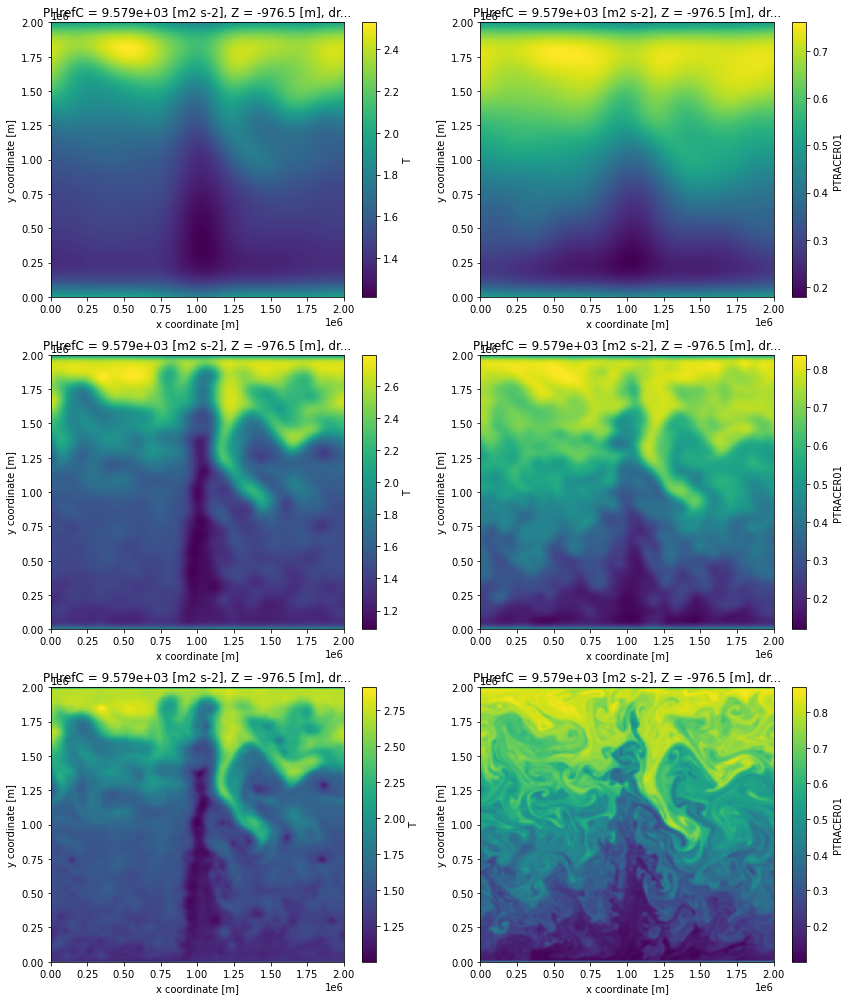

In [8]:
# Maps 

fig, ax = plt.subplots(3, 2, figsize=(12, 14))
depth = -1000

T_filt['400'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[0,0])
C_filt['400'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[0,1])

T_filt['100'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[1,0])
C_filt['100'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[1,1])

T_filt['25'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[2,0])
C_filt['25'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[2,1])


plt.tight_layout()

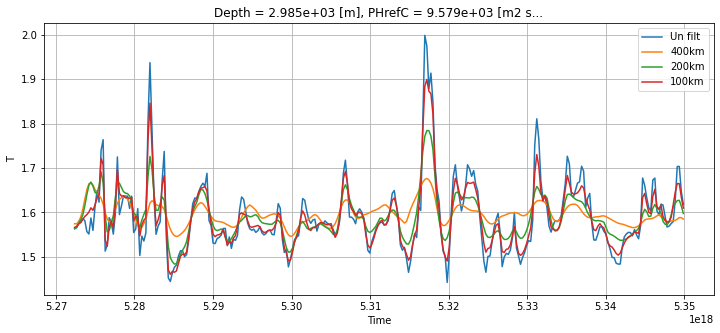

In [15]:
# Time series 

Ysel = 1000e3 
Xsel = 0
Zsel = -1000 
Tsel = slice(0, 300)

plt.figure(figsize=(12, 5))

T_field.sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='Un filt')
T_filt['400'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='400km')
T_filt['200'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='200km')
T_filt['100'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='100km')

plt.legend()
plt.grid()

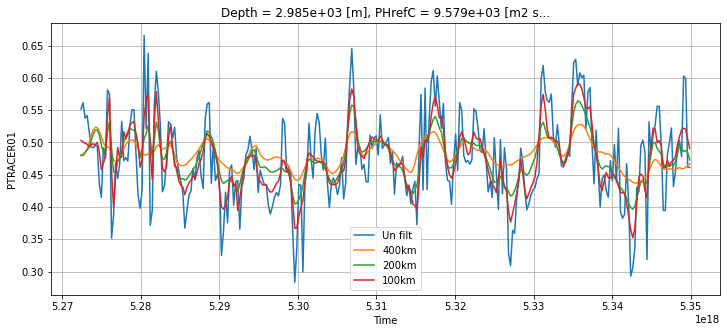

In [140]:
# Time series 

Ysel = 1000e3 
Xsel = 0
Zsel = -1000 
Tsel = slice(0, 300)

plt.figure(figsize=(12, 5))

C_field.sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='Un filt')
C_filt['400'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='400km')
C_filt['200'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='200km')
C_filt['100'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='100km')

plt.legend()
plt.grid()

In [124]:
T_filt_om_ps_20m = {}
T_filt_om_ps_1000m = {}

for L_key in T_filt.keys():
    # 20m
    T_sel = T_filt[L_key].isel(time=slice(0,1800)).sel(
        XC=slice(0,1000e3), YC=slice(500e3, 1500e3) 
        ).sel(Z=-20, method='nearest').drop(
        ['Depth', 'hFacC', 'maskC', 'rA', 'iter']).chunk({'XC':10, 'time':600, 'YC':10})
    T_sel['time'] = ((T_sel.time - T_sel.time[0])/1e9/24/3600).astype('float')
    
    T_filt_om_ps_20m[L_key] = xrft.power_spectrum(T_sel, dim=['time'] , chunks_to_segments=True).rename('T_k_om_ps').mean(['YC', 'time_segment', 'XC']).load()
    
    #1000m
    T_sel = T_filt[L_key].isel(time=slice(0,1800)).sel(
        XC=slice(0,1000e3), YC=slice(500e3, 1500e3) 
        ).sel(Z=-1000, method='nearest').drop(
        ['Depth', 'hFacC', 'maskC', 'rA', 'iter']).chunk({'XC':10, 'time':600, 'YC':10})
    T_sel['time'] = ((T_sel.time - T_sel.time[0])/1e9/24/3600).astype('float')
    T_filt_om_ps_1000m[L_key] = xrft.power_spectrum(T_sel, dim=['time'] , chunks_to_segments=True).rename('T_k_om_ps').mean(['YC', 'time_segment', 'XC']).load()

(1e-06, 1)

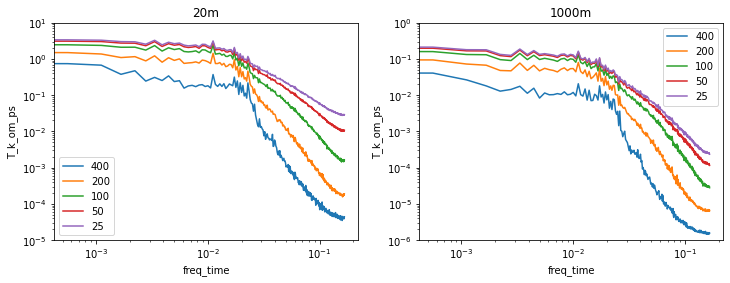

In [126]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
for L_key in T_filt.keys(): 
    T_filt_om_ps_20m[L_key].plot(label=L_key)
    
plt.title('20m')
plt.xscale('log')
plt.yscale('log')    
plt.legend()
plt.ylim([1e-5, 10])

plt.subplot(122)
for L_key in T_filt.keys(): 
    T_filt_om_ps_1000m[L_key].plot(label=L_key)
    
plt.title('1000m')
plt.xscale('log')
plt.yscale('log')    
plt.legend()
plt.ylim([1e-6, 1])

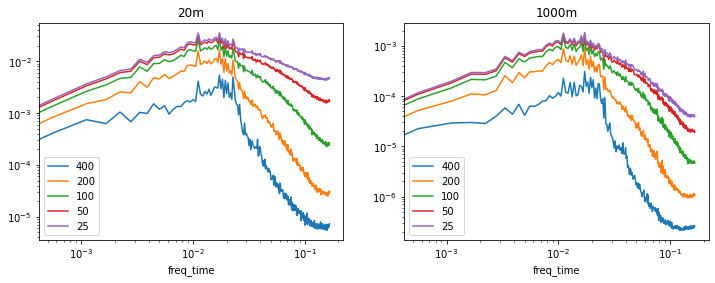

In [128]:
plt.figure(figsize=(12, 4))

om = T_filt_om_ps_20m['400'].freq_time

plt.subplot(121)
for L_key in T_filt.keys(): 
    (T_filt_om_ps_20m[L_key]*om).plot(label=L_key)
    
plt.title('20m')
plt.xscale('log')
plt.yscale('log')    
plt.legend()
#plt.ylim([1e-6, 1])

plt.subplot(122)
for L_key in T_filt.keys(): 
    (T_filt_om_ps_1000m[L_key]*om).plot(label=L_key)
    
plt.title('1000m')
plt.xscale('log')
plt.yscale('log')    
plt.legend()


In [141]:
C_filt_om_ps_20m = {}
C_filt_om_ps_1000m = {}

for L_key in C_filt.keys():
    # 20m
    C_sel = C_filt[L_key].isel(time=slice(0,1800)).sel(
        XC=slice(0,1000e3), YC=slice(500e3, 1500e3) 
        ).sel(Z=-20, method='nearest').drop(
        ['Depth', 'hFacC', 'maskC', 'rA', 'iter']).chunk({'XC':10, 'time':600, 'YC':10})
    C_sel['time'] = ((C_sel.time - C_sel.time[0])/1e9/24/3600).astype('float')
    
    C_filt_om_ps_20m[L_key] = xrft.power_spectrum(C_sel, dim=['time'] , chunks_to_segments=True).rename('T_k_om_ps').mean(['YC', 'time_segment', 'XC']).load()
    
    #1000m
    C_sel = C_filt[L_key].isel(time=slice(0,1800)).sel(
        XC=slice(0,1000e3), YC=slice(500e3, 1500e3) 
        ).sel(Z=-1000, method='nearest').drop(
        ['Depth', 'hFacC', 'maskC', 'rA', 'iter']).chunk({'XC':10, 'time':600, 'YC':10})
    C_sel['time'] = ((C_sel.time - C_sel.time[0])/1e9/24/3600).astype('float')
    C_filt_om_ps_1000m[L_key] = xrft.power_spectrum(C_sel, dim=['time'] , chunks_to_segments=True).rename('T_k_om_ps').mean(['YC', 'time_segment', 'XC']).load()

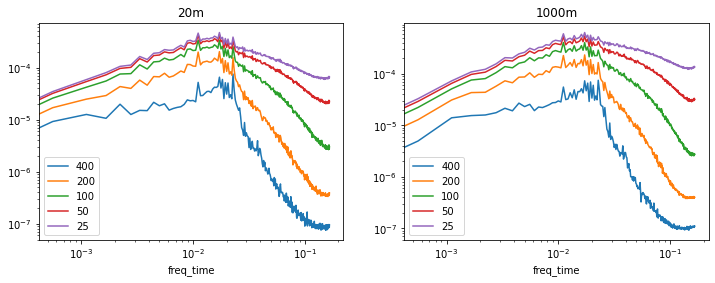

In [143]:
plt.figure(figsize=(12, 4))

om = C_filt_om_ps_20m['400'].freq_time

plt.subplot(121)
for L_key in T_filt.keys(): 
    (C_filt_om_ps_20m[L_key]*om).plot(label=L_key)
    
plt.title('20m')
plt.xscale('log')
plt.yscale('log')    
plt.legend()
#plt.ylim([1e-6, 1])

plt.subplot(122)
for L_key in T_filt.keys(): 
    (C_filt_om_ps_1000m[L_key]*om).plot(label=L_key)
    
plt.title('1000m')
plt.xscale('log')
plt.yscale('log')    
plt.legend()


Spatial averaging kills time scales at the smaller scales, but as filter size increases the energy at the largest scales is also damped. This bhavior is linked in some manner to the om-k spectra we showed earlier.

This also physically makes sense, because the dominant mode of variability is the mesoscale. This has time variability of about 50-100 days and length scales of about 100km. As we filter beyond 100km the time variability at all frequencies starts to decline, while before that it was mostly a decline in the high freq tail of the spectrum.

### Time Average

In [131]:
def time_filter(da, Tscale = 99):
    # Tscale is in days
    coarsen_points = int(Tscale/3.) # 3 is set by snapshot output
    return da.coarsen(time=coarsen_points, boundary='trim').mean()

In [132]:
Tfilters = [450, 180, 90, 45, 15]

In [135]:
T_filt_time = {}
C_filt_time = {}

for T in Tfilters: 
    T_filt_time[str(int(T))] = time_filter(T_field, T)
    C_filt_time[str(int(T))] = time_filter(C_field, T)    

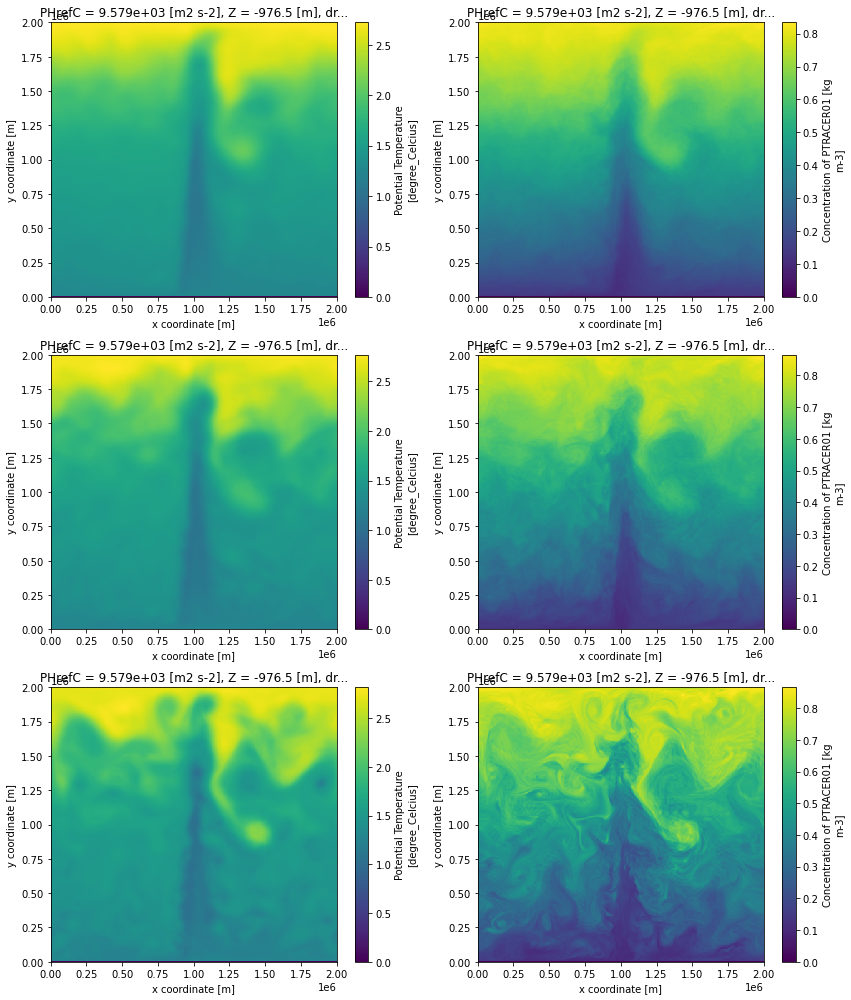

In [136]:
# Maps 

fig, ax = plt.subplots(3, 2, figsize=(12, 14))
depth = -1000

T_filt_time['450'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[0,0])
C_filt_time['450'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[0,1])

T_filt_time['90'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[1,0])
C_filt_time['90'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[1,1])

T_filt_time['15'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[2,0])
C_filt_time['15'].isel(time=0).sel(Z=depth, method='nearest').plot(ax = ax[2,1])


plt.tight_layout()

(5.3e+18, 5.45e+18)

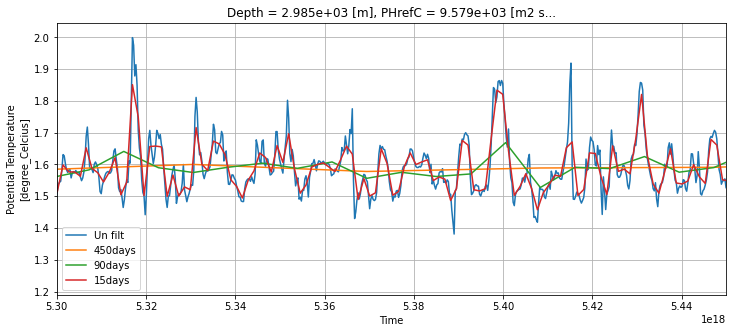

In [139]:
# Time series 

Ysel = 1000e3 
Xsel = 0
Zsel = -1000 
Tsel = slice(0, -1)

plt.figure(figsize=(12, 5))

T_field.sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='Un filt')
T_filt_time['450'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='450days')
T_filt_time['90'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='90days')
T_filt_time['15'].sel(XC=Xsel, YC=Ysel, Z=Zsel, method='nearest').isel(time=Tsel).plot(label='15days')

plt.legend()
plt.grid()
plt.xlim([5.3e18, 5.45e18])

In [153]:
T_filt_k_ps_20m = {}
T_filt_k_ps_1000m = {}

for T_key in T_filt_time.keys():
    # 20m
    T_sel = T_filt_time[T_key].isel(time=slice(0,100)).sel(YC=slice(500e3, 1500e3)
                                             ).sel(Z=-20, method='nearest').drop(
                                ['Depth', 'hFacC', 'maskC', 'rA', 'iter']).chunk({'time':10, 'YC':10})
    T_sel['time'] = ((T_sel.time - T_sel.time[0])/1e9/24/3600).astype('float')
    
    T_filt_k_ps_20m[T_key] = xrft.power_spectrum(T_sel, dim=['XC'] ).rename('T_k_om_ps').mean(['YC', 'time']).load()
    
    #1000m
    T_sel = T_filt_time[T_key].isel(time=slice(0,100)).sel(YC=slice(500e3, 1500e3)
                                             ).sel(Z=-1000, method='nearest').drop(
                                ['Depth', 'hFacC', 'maskC', 'rA', 'iter']).chunk({'time':10, 'YC':10})
    T_sel['time'] = ((T_sel.time - T_sel.time[0])/1e9/24/3600).astype('float')
    
    T_filt_k_ps_1000m[T_key] = xrft.power_spectrum(T_sel, dim=['XC'] ).rename('T_k_om_ps').mean(['YC', 'time']).load()   

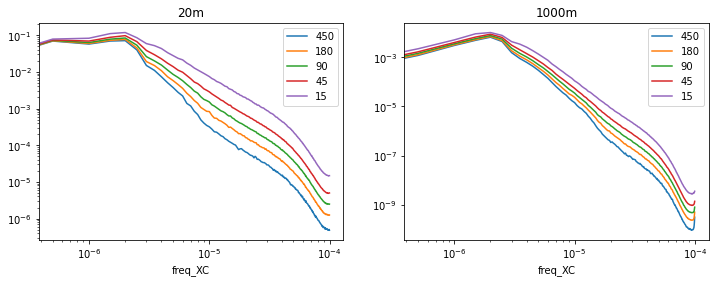

In [154]:
plt.figure(figsize=(12, 4))

k = T_filt_k_ps_20m['450'].freq_XC

plt.subplot(121)
for L_key in T_filt_time.keys(): 
    (T_filt_k_ps_20m[L_key]*k).plot(label=L_key)
    
plt.title('20m')
plt.xscale('log')
plt.yscale('log')    
plt.legend()
#plt.ylim([1e-6, 1])

plt.subplot(122)
for L_key in T_filt_time.keys(): 
    (T_filt_k_ps_1000m[L_key]*k).plot(label=L_key)
    
plt.title('1000m')
plt.xscale('log')
plt.yscale('log')    
plt.legend()


The spectrum steepens with increased time filtering. The lack of change in the bump energy with filter scale may be a result of it being a signature of the standing wave, which says the same betweem resolutions. 